In [751]:
'''
ALL CODE ORIGINALLY FROM: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

'''

from __future__ import print_function
import keras
#from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import PIL.Image
import PIL.ImageDraw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# to implement batches of data - reducing dataset size for code debug and dev
# see: https://github.com/Britefury/batchup
from batchup import data_source

In [2]:
'''
Amalgamated with code from: https://github.com/hangyao/street_view_house_numbers/blob/master/4_CNN_multi.ipynb
AND
https://github.com/keras-team/keras/issues/3928
'''

from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

pickle_file = '/Users/billcoleman/NOTEBOOKS/DEEP_LEARNING_TUD/ASSIGNMENT/street_view_house_numbers-master/SVHN_multi.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [263]:
# 1 slot for how many digits are in the instance, 10 slots for digits 0 - 9
num_classes = 11

# batch_size = 32
# epochs = 5
# data_augmentation = False
# num_predictions = 20
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'keras_svhnI_trained_model.h5'

In [264]:
# The data, split between train and test sets:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('train_dataset shape:', train_dataset.shape)
print('train_labels shape:', train_labels.shape)
print('valid_dataset shape:', valid_dataset.shape)
print('valid_labels shape:', valid_labels.shape)
print('test_dataset shape:', test_dataset.shape)
print('test_labels shape:', test_labels.shape)

train_dataset shape: (230070, 32, 32, 1)
train_labels shape: (230070, 6)
valid_dataset shape: (5684, 32, 32, 1)
valid_labels shape: (5684, 6)
test_dataset shape: (13068, 32, 32, 1)
test_labels shape: (13068, 6)


In [288]:
# Note that the first entry in the array as it stands is the number of digits in the instance.
# Other array entries are which digits are in which slot

test_labels[17]

array([ 2,  3,  8, 10, 10, 10])

In [287]:
# slice the first entry in each array off
train_labels_clip = train_labels[:,1:6]
train_labels_clip[17]

array([ 1,  9, 10, 10, 10])

In [808]:
valid_labels_clip = valid_labels[:,1:6]
valid_labels_clip[17]

array([ 4,  6, 10, 10, 10])

In [289]:
test_labels_clip = test_labels[:,1:6]
test_labels_clip[17]

array([ 3,  8, 10, 10, 10])

In [236]:
img = train_dataset[1]

img.reshape(2, -1)

newimg = np.squeeze(img)

In [237]:
%matplotlib inline

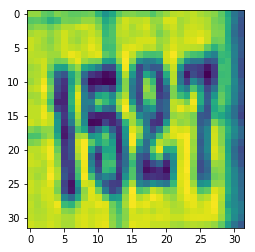

In [238]:
imgplot = plt.imshow(newimg)
imgplot

In [809]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(train_labels_clip, num_classes)
y_valid = keras.utils.to_categorical(valid_labels_clip, num_classes)
y_test = keras.utils.to_categorical(test_labels_clip, num_classes)

#y_train = train_labels
#y_test = test_labels

In [810]:
y_train.shape, y_valid.shape, y_test.shape

((230070, 5, 11), (5684, 5, 11), (13068, 5, 11))

In [811]:
# Construct an array data source
# ds_train = data_source.ArrayDataSource([x_train, y_train])

train_corpus = 2048; # 512
valid_corpus = 512; # 
test_corpus = 512; # 128

# Randomly choose a subset of 2048 training samples, by indices
subset_train = np.random.permutation(train_dataset.shape[0])[:train_corpus]

# Randomly choose a subset of 512 test/validation samples, by indices
subset_test = np.random.permutation(test_dataset.shape[0])[:test_corpus]
subset_valid = np.random.permutation(valid_dataset.shape[0])[:valid_corpus]

# Construct an array data source that will only draw training samples whose indices are in `subset_train`
ds_train = data_source.ArrayDataSource([train_dataset, y_train], indices=subset_train)

# Construct an array data source that will only draw test samples whose indices are in `subset_valid`
ds_valid = data_source.ArrayDataSource([valid_dataset, y_valid], indices=subset_valid)

# Construct an array data source that will only draw test samples whose indices are in `subset_test`
ds_test = data_source.ArrayDataSource([test_dataset, y_test], indices=subset_test)

print(subset_train.shape, subset_valid.shape, subset_test.shape)

(2048,) (512,) (512,)


In [769]:
type(ds_test)

batchup.data_source.ArrayDataSource

In [812]:
#### TRAIN ####
# bunch this random selection into one array - first set up a dummy...
x_train_subset = np.ones([1, 32, 32, 1])
y_train_subset = np.ones([1, 5, 11])
print("x_train_subset init shape = ", x_train_subset.shape)
print("y_train_subset init shape = ", y_train_subset.shape)

for (batch_X, batch_y) in ds_train.batch_iterator(batch_size=256, shuffle=np.random.RandomState(12345)):
    print("batch_X shape = ", batch_X.shape)
    print("batch_y shape = ", batch_y.shape)
    # Processes batches here...
    # Then join them all together
    x_train_subset = np.concatenate((x_train_subset, batch_X))
    y_train_subset = np.concatenate((y_train_subset, batch_y))
    print("x_train_subset shape = ", x_train_subset.shape)
    print("y_train_subset shape = ", y_train_subset.shape)

#### VALIDATION ####
# bunch this random selection into one array - first set up a dummy...
x_valid_subset = np.ones([1, 32, 32, 1])
y_valid_subset = np.ones([1, 5, 11])
print("x_valid_subset init shape = ", x_valid_subset.shape)
print("y_valid_subset init shape = ", y_valid_subset.shape)

# Drawing batches of 32 elements in random order - Check the test subset
for (batch_X, batch_y) in ds_valid.batch_iterator(batch_size=256, shuffle=np.random.RandomState(12345)):
    # Processes batches here...
    # Then join them all together
    x_valid_subset = np.concatenate((x_valid_subset, batch_X))
    y_valid_subset = np.concatenate((y_valid_subset, batch_y))
    print("x_valid_subset shape = ", x_valid_subset.shape)
    print("y_valid_subset shape = ", y_valid_subset.shape)

#### TEST ####
# bunch this random selection into one array - first set up a dummy...
x_test_subset = np.ones([1, 32, 32, 1])
y_test_subset = np.ones([1, 5, 11])
print("x_test_subset init shape = ", x_test_subset.shape)
print("y_test_subset init shape = ", y_test_subset.shape)

# Drawing batches of 32 elements in random order - Check the test subset
for (batch_X, batch_y) in ds_test.batch_iterator(batch_size=256, shuffle=np.random.RandomState(12345)):
    # Processes batches here...
    # Then join them all together
    x_test_subset = np.concatenate((x_test_subset, batch_X))
    y_test_subset = np.concatenate((y_test_subset, batch_y))
    print("x_test_subset shape = ", x_test_subset.shape)
    print("y_test_subset shape = ", y_test_subset.shape)
    

x_train_subset init shape =  (1, 32, 32, 1)
y_train_subset init shape =  (1, 5, 11)
batch_X shape =  (256, 32, 32, 1)
batch_y shape =  (256, 5, 11)
x_train_subset shape =  (257, 32, 32, 1)
y_train_subset shape =  (257, 5, 11)
batch_X shape =  (256, 32, 32, 1)
batch_y shape =  (256, 5, 11)
x_train_subset shape =  (513, 32, 32, 1)
y_train_subset shape =  (513, 5, 11)
batch_X shape =  (256, 32, 32, 1)
batch_y shape =  (256, 5, 11)
x_train_subset shape =  (769, 32, 32, 1)
y_train_subset shape =  (769, 5, 11)
batch_X shape =  (256, 32, 32, 1)
batch_y shape =  (256, 5, 11)
x_train_subset shape =  (1025, 32, 32, 1)
y_train_subset shape =  (1025, 5, 11)
batch_X shape =  (256, 32, 32, 1)
batch_y shape =  (256, 5, 11)
x_train_subset shape =  (1281, 32, 32, 1)
y_train_subset shape =  (1281, 5, 11)
batch_X shape =  (256, 32, 32, 1)
batch_y shape =  (256, 5, 11)
x_train_subset shape =  (1537, 32, 32, 1)
y_train_subset shape =  (1537, 5, 11)
batch_X shape =  (256, 32, 32, 1)
batch_y shape =  (256, 5

In [813]:
x_train_subset = np.delete(x_train_subset, (0), axis=0)
y_train_subset = np.delete(y_train_subset, (0), axis=0)
x_valid_subset = np.delete(x_valid_subset, (0), axis=0)
y_valid_subset = np.delete(y_valid_subset, (0), axis=0)
x_test_subset = np.delete(x_test_subset, (0), axis=0)
y_test_subset = np.delete(y_test_subset, (0), axis=0)

print(x_train_subset.shape)
print(y_train_subset.shape)
print(x_valid_subset.shape)
print(y_valid_subset.shape)
print(x_test_subset.shape)
print(y_test_subset.shape)

(2048, 32, 32, 1)
(2048, 5, 11)
(512, 32, 32, 1)
(512, 5, 11)
(512, 32, 32, 1)
(512, 5, 11)


In [814]:
y_train_final = []

for i in range (5):
    y_train_final.append(y_train_subset[:,i])

In [815]:
y_train_final[4][127]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [816]:
y_valid_final = []

for i in range (5):
    y_valid_final.append(y_valid_subset[:,i])

In [821]:
y_valid_final[0][127]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [818]:
y_test_final = []

for i in range (5):
    y_test_final.append(y_test_subset[:,i])

In [819]:
y_test_final[0][127]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [776]:
x_train_final.shape[0]

512

In [590]:
# big = 0
# small = 0

# for inst in range(0,1023):
#     for dim1 in range(0,31):
#         for dim2 in range(0,31):
#             big = max(x_train_final[inst][dim1])
#             small = min(x_train_final[inst][dim1])

# print('big = ', big)
# print('small = ', small)

big =  [0.74822843]
small =  [-0.30507216]


In [820]:
x_train_final = x_train_subset.astype('float32')
x_valid_final = x_valid_subset.astype('float32')
x_test_final = x_test_subset.astype('float32')

print("AFTER - ", x_train_final.shape)
print("AFTER - ", x_valid_final.shape)
print("AFTER - ", x_test_final.shape)

AFTER -  (2048, 32, 32, 1)
AFTER -  (512, 32, 32, 1)
AFTER -  (512, 32, 32, 1)


In [727]:
# Implementing f1 score, recall and precision
# Compiled from: https://keras.io/metrics/
# Compiled from: https://github.com/keras-team/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7

import keras.backend as K

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

In [822]:
# https://github.com/keras-team/keras/issues/3928

from keras.layers import Input, Dense, Conv2D
from keras.models import Model
from keras.constraints import max_norm
from keras import optimizers

batch_size = 32 # 32 seems to work better than 64
nb_classes = 11
nb_epoch = 50

_, img_rows, img_cols, img_channels = x_train_final.shape

model_input = Input(shape=(img_rows, img_cols, img_channels))

# https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

x = Conv2D(32, (3, 3), padding='same')(model_input)
x = Activation('relu')(x)
x = BatchNormalization()(x) # added batchnorm
x = Conv2D(32, (3, 3))(x)
x = BatchNormalization()(x) # added batchnorm
x = Activation('relu')(x)
x = BatchNormalization()(x) # added batchnorm
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x) # 0.25, 0.1 were overfitting

x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x) # added batchnorm
x = Conv2D(64, (3, 3))(x)
x = BatchNormalization()(x) # added batchnorm
x = Activation('relu')(x)
x = BatchNormalization()(x) # added batchnorm
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(128, (5, 5), padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x) # added batchnorm
x = Conv2D(128, (5, 5))(x)
x = BatchNormalization()(x) # added batchnorm
x = Activation('relu')(x)
x = BatchNormalization()(x) # added batchnorm
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

conv_out = Flatten()(x)

x1 = Dense(nb_classes, activation='softmax', name='D1')(conv_out)
x2 = Dense(nb_classes, activation='softmax', name='D2')(conv_out)
x3 = Dense(nb_classes, activation='softmax', name='D3')(conv_out)
x4 = Dense(nb_classes, activation='softmax', name='D4')(conv_out)
x5 = Dense(nb_classes, activation='softmax', name='D5')(conv_out)

lst = [x1, x2, x3, x4, x5]

model = Model(input=model_input, output=lst)


# initial lr=0.001 - changing this to 0.01 led to a big disparity between train & validate D1 acc.
# this was in tandem with clamping network weights [kernel_constraint=max_norm(4.)]
adam = optimizers.Adam(lr=0.001, 
                       beta_1=0.9, 
                       beta_2=0.999, 
                       epsilon=None, 
                       decay=0.0, 
                       amsgrad=False)

model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy', precision, recall, fmeasure])

initModel = model.fit(x_train_final,
                      y_train_final, 
                      batch_size=batch_size, 
                      epochs=nb_epoch, 
                      verbose=1, 
                      validation_data=(x_valid_final, y_valid_final))

/Users/billcoleman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Train on 2048 samples, validate on 512 samples
Epoch 1/50
2048/2048 [==============================] - 156s 76ms/step - loss: 12.7920 - D1_loss: 3.6760 - D2_loss: 3.7770 - D3_loss: 3.1438 - D4_loss: 1.1620 - D5_loss: 1.0333 - D1_acc: 0.1455 - D1_precision: 0.1624 - D1_recall: 0.0693 - D1_fmeasure: 0.0960 - D2_acc: 0.1089 - D2_precision: 0.1192 - D2_recall: 0.0469 - D2_fmeasure: 0.0656 - D3_acc: 0.3184 - D3_precision: 0.4125 - D3_recall: 0.2383 - D3_fmeasure: 0.2997 - D4_acc: 0.7300 - D4_precision: 0.7848 - D4_recall: 0.6455 - D4_fmeasure: 0.7068 - D5_acc: 0.7651 - D5_precision: 0.8217 - D5_recall: 0.6841 - D5_fmeasure: 0.7442 - val_loss: 6.2258 - val_D1_loss: 2.5510 - val_D2_loss: 2.2203 - val_D3_loss: 1.1977 - val_D4_loss: 0.2046 - val_D5_loss: 0.0522 - val_D1_acc: 0.1621 - val_D1_precision: 0.1812 - val_D1_recall: 0.0117 - val_D1_fmeasure: 0.0216 - val_D2_acc: 0.2363 - val_D2_precision: 0.6528 - val_D2_recall: 0.0938 - val_D2_fmeasure: 0.1586 - val_D3_acc: 0.6895 - val_D3_precision: 

Epoch 8/50
2048/2048 [==============================] - 140s 68ms/step - loss: 4.2270 - D1_loss: 1.1307 - D2_loss: 1.5152 - D3_loss: 1.2375 - D4_loss: 0.3084 - D5_loss: 0.0352 - D1_acc: 0.6309 - D1_precision: 0.7372 - D1_recall: 0.5327 - D1_fmeasure: 0.6169 - D2_acc: 0.4927 - D2_precision: 0.6559 - D2_recall: 0.3545 - D2_fmeasure: 0.4583 - D3_acc: 0.6021 - D3_precision: 0.7793 - D3_recall: 0.4971 - D3_fmeasure: 0.6045 - D4_acc: 0.9224 - D4_precision: 0.9564 - D4_recall: 0.9067 - D4_fmeasure: 0.9306 - D5_acc: 0.9956 - D5_precision: 0.9980 - D5_recall: 0.9927 - D5_fmeasure: 0.9953 - val_loss: 3.3405 - val_D1_loss: 1.2743 - val_D2_loss: 1.2076 - val_D3_loss: 0.7089 - val_D4_loss: 0.1475 - val_D5_loss: 0.0022 - val_D1_acc: 0.6074 - val_D1_precision: 0.7463 - val_D1_recall: 0.5039 - val_D1_fmeasure: 0.6002 - val_D2_acc: 0.6055 - val_D2_precision: 0.8024 - val_D2_recall: 0.3906 - val_D2_fmeasure: 0.5230 - val_D3_acc: 0.7891 - val_D3_precision: 0.9275 - val_D3_recall: 0.6680 - val_D3_fmeasure

Epoch 15/50
2048/2048 [==============================] - 136s 67ms/step - loss: 2.4536 - D1_loss: 0.6258 - D2_loss: 0.8295 - D3_loss: 0.7759 - D4_loss: 0.2030 - D5_loss: 0.0194 - D1_acc: 0.8062 - D1_precision: 0.8649 - D1_recall: 0.7319 - D1_fmeasure: 0.7917 - D2_acc: 0.7295 - D2_precision: 0.8450 - D2_recall: 0.6099 - D2_fmeasure: 0.7065 - D3_acc: 0.7476 - D3_precision: 0.8743 - D3_recall: 0.6455 - D3_fmeasure: 0.7412 - D4_acc: 0.9385 - D4_precision: 0.9693 - D4_recall: 0.9248 - D4_fmeasure: 0.9462 - D5_acc: 0.9980 - D5_precision: 0.9985 - D5_recall: 0.9956 - D5_fmeasure: 0.9970 - val_loss: 2.2336 - val_D1_loss: 0.9023 - val_D2_loss: 0.7383 - val_D3_loss: 0.4647 - val_D4_loss: 0.1264 - val_D5_loss: 0.0019 - val_D1_acc: 0.7324 - val_D1_precision: 0.8270 - val_D1_recall: 0.6660 - val_D1_fmeasure: 0.7365 - val_D2_acc: 0.7930 - val_D2_precision: 0.8859 - val_D2_recall: 0.6797 - val_D2_fmeasure: 0.7669 - val_D3_acc: 0.8438 - val_D3_precision: 0.9440 - val_D3_recall: 0.7969 - val_D3_fmeasur

Epoch 22/50
2048/2048 [==============================] - 136s 66ms/step - loss: 1.6266 - D1_loss: 0.4224 - D2_loss: 0.5561 - D3_loss: 0.4791 - D4_loss: 0.1560 - D5_loss: 0.0131 - D1_acc: 0.8623 - D1_precision: 0.9094 - D1_recall: 0.8159 - D1_fmeasure: 0.8596 - D2_acc: 0.8140 - D2_precision: 0.8821 - D2_recall: 0.7505 - D2_fmeasure: 0.8098 - D3_acc: 0.8433 - D3_precision: 0.9139 - D3_recall: 0.7817 - D3_fmeasure: 0.8417 - D4_acc: 0.9526 - D4_precision: 0.9733 - D4_recall: 0.9390 - D4_fmeasure: 0.9556 - D5_acc: 0.9971 - D5_precision: 0.9995 - D5_recall: 0.9956 - D5_fmeasure: 0.9975 - val_loss: 1.9758 - val_D1_loss: 0.7969 - val_D2_loss: 0.6377 - val_D3_loss: 0.4065 - val_D4_loss: 0.1336 - val_D5_loss: 0.0011 - val_D1_acc: 0.7461 - val_D1_precision: 0.8320 - val_D1_recall: 0.7051 - val_D1_fmeasure: 0.7617 - val_D2_acc: 0.8203 - val_D2_precision: 0.8828 - val_D2_recall: 0.7520 - val_D2_fmeasure: 0.8112 - val_D3_acc: 0.8574 - val_D3_precision: 0.9313 - val_D3_recall: 0.8047 - val_D3_fmeasur

Epoch 29/50
2048/2048 [==============================] - 136s 67ms/step - loss: 1.1475 - D1_loss: 0.2943 - D2_loss: 0.3902 - D3_loss: 0.3491 - D4_loss: 0.1003 - D5_loss: 0.0136 - D1_acc: 0.9033 - D1_precision: 0.9320 - D1_recall: 0.8823 - D1_fmeasure: 0.9061 - D2_acc: 0.8740 - D2_precision: 0.9205 - D2_recall: 0.8325 - D2_fmeasure: 0.8737 - D3_acc: 0.8823 - D3_precision: 0.9328 - D3_recall: 0.8394 - D3_fmeasure: 0.8829 - D4_acc: 0.9697 - D4_precision: 0.9843 - D4_recall: 0.9541 - D4_fmeasure: 0.9687 - D5_acc: 0.9961 - D5_precision: 0.9980 - D5_recall: 0.9932 - D5_fmeasure: 0.9956 - val_loss: 1.9065 - val_D1_loss: 0.7907 - val_D2_loss: 0.6056 - val_D3_loss: 0.3800 - val_D4_loss: 0.1300 - val_D5_loss: 2.4313e-04 - val_D1_acc: 0.7832 - val_D1_precision: 0.8301 - val_D1_recall: 0.7539 - val_D1_fmeasure: 0.7892 - val_D2_acc: 0.8184 - val_D2_precision: 0.8773 - val_D2_recall: 0.7891 - val_D2_fmeasure: 0.8300 - val_D3_acc: 0.8770 - val_D3_precision: 0.9155 - val_D3_recall: 0.8477 - val_D3_fme

Epoch 36/50
2048/2048 [==============================] - 137s 67ms/step - loss: 0.8487 - D1_loss: 0.2140 - D2_loss: 0.2951 - D3_loss: 0.2602 - D4_loss: 0.0712 - D5_loss: 0.0081 - D1_acc: 0.9331 - D1_precision: 0.9467 - D1_recall: 0.9150 - D1_fmeasure: 0.9302 - D2_acc: 0.9087 - D2_precision: 0.9377 - D2_recall: 0.8765 - D2_fmeasure: 0.9057 - D3_acc: 0.9155 - D3_precision: 0.9422 - D3_recall: 0.8882 - D3_fmeasure: 0.9140 - D4_acc: 0.9785 - D4_precision: 0.9900 - D4_recall: 0.9688 - D4_fmeasure: 0.9790 - D5_acc: 0.9976 - D5_precision: 1.0000 - D5_recall: 0.9971 - D5_fmeasure: 0.9985 - val_loss: 1.8540 - val_D1_loss: 0.7986 - val_D2_loss: 0.5535 - val_D3_loss: 0.3648 - val_D4_loss: 0.1369 - val_D5_loss: 2.0814e-04 - val_D1_acc: 0.8066 - val_D1_precision: 0.8435 - val_D1_recall: 0.7910 - val_D1_fmeasure: 0.8160 - val_D2_acc: 0.8438 - val_D2_precision: 0.8944 - val_D2_recall: 0.8242 - val_D2_fmeasure: 0.8571 - val_D3_acc: 0.8945 - val_D3_precision: 0.9172 - val_D3_recall: 0.8809 - val_D3_fme

Epoch 43/50
2048/2048 [==============================] - 142s 70ms/step - loss: 0.6489 - D1_loss: 0.1679 - D2_loss: 0.2172 - D3_loss: 0.1928 - D4_loss: 0.0662 - D5_loss: 0.0048 - D1_acc: 0.9443 - D1_precision: 0.9606 - D1_recall: 0.9336 - D1_fmeasure: 0.9468 - D2_acc: 0.9282 - D2_precision: 0.9450 - D2_recall: 0.9165 - D2_fmeasure: 0.9303 - D3_acc: 0.9346 - D3_precision: 0.9609 - D3_recall: 0.9136 - D3_fmeasure: 0.9362 - D4_acc: 0.9785 - D4_precision: 0.9866 - D4_recall: 0.9702 - D4_fmeasure: 0.9782 - D5_acc: 0.9995 - D5_precision: 0.9995 - D5_recall: 0.9985 - D5_fmeasure: 0.9990 - val_loss: 1.9620 - val_D1_loss: 0.8437 - val_D2_loss: 0.5930 - val_D3_loss: 0.3942 - val_D4_loss: 0.1310 - val_D5_loss: 2.2104e-04 - val_D1_acc: 0.7988 - val_D1_precision: 0.8347 - val_D1_recall: 0.7812 - val_D1_fmeasure: 0.8064 - val_D2_acc: 0.8438 - val_D2_precision: 0.8762 - val_D2_recall: 0.8242 - val_D2_fmeasure: 0.8490 - val_D3_acc: 0.8926 - val_D3_precision: 0.9212 - val_D3_recall: 0.8750 - val_D3_fme

Epoch 50/50
2048/2048 [==============================] - 136s 66ms/step - loss: 0.5325 - D1_loss: 0.1397 - D2_loss: 0.1866 - D3_loss: 0.1516 - D4_loss: 0.0477 - D5_loss: 0.0070 - D1_acc: 0.9531 - D1_precision: 0.9636 - D1_recall: 0.9448 - D1_fmeasure: 0.9540 - D2_acc: 0.9380 - D2_precision: 0.9496 - D2_recall: 0.9229 - D2_fmeasure: 0.9358 - D3_acc: 0.9531 - D3_precision: 0.9626 - D3_recall: 0.9365 - D3_fmeasure: 0.9491 - D4_acc: 0.9849 - D4_precision: 0.9916 - D4_recall: 0.9814 - D4_fmeasure: 0.9865 - D5_acc: 0.9980 - D5_precision: 0.9985 - D5_recall: 0.9976 - D5_fmeasure: 0.9980 - val_loss: 1.8166 - val_D1_loss: 0.7860 - val_D2_loss: 0.5276 - val_D3_loss: 0.3759 - val_D4_loss: 0.1265 - val_D5_loss: 5.6254e-04 - val_D1_acc: 0.8184 - val_D1_precision: 0.8369 - val_D1_recall: 0.8008 - val_D1_fmeasure: 0.8180 - val_D2_acc: 0.8555 - val_D2_precision: 0.8826 - val_D2_recall: 0.8359 - val_D2_fmeasure: 0.8583 - val_D3_acc: 0.8887 - val_D3_precision: 0.9180 - val_D3_recall: 0.8730 - val_D3_fme

In [823]:
save_dir = os.path.join(os.getcwd(), 'saved_models')

# Save model and weights
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
model_name = 'keras_svhnIII_tr%d_te%d_ep%d.h5' % (train_corpus,
                                                 test_corpus, 
                                                 nb_epoch)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/billcoleman/NOTEBOOKS/DEEP_LEARNING_TUD/ASSIGNMENT/saved_models/keras_svhnIII_tr2048_te512_ep50.h5 


In [824]:
# model.summary()

print("D1 Val Acc: ", initModel.history['val_D1_acc'][49])
print("D2 Val Acc: ", initModel.history['val_D2_acc'][49])
print("D3 Val Acc: ", initModel.history['val_D3_acc'][49])
print("D4 Val Acc: ", initModel.history['val_D4_acc'][49])
print("D5 Val Acc: ", initModel.history['val_D5_acc'][49])
print("D1 Val F Score: ", initModel.history['val_D1_fmeasure'][49])
print("D2 Val F Score: ", initModel.history['val_D2_fmeasure'][49])
print("D3 Val F Score: ", initModel.history['val_D3_fmeasure'][49])
print("D4 Val F Score: ", initModel.history['val_D4_fmeasure'][49])
print("D5 Val F Score: ", initModel.history['val_D5_fmeasure'][49])

D1 Val Acc:  0.818359375
D2 Val Acc:  0.85546875
D3 Val Acc:  0.888671875
D4 Val Acc:  0.96875
D5 Val Acc:  1.0
D1 Val F Score:  0.8179645054042339
D2 Val F Score:  0.8583292067050934
D3 Val F Score:  0.8943595960736275
D4 Val F Score:  0.9762184470891953
D5 Val F Score:  1.0


In [827]:
evalInitModel = model.evaluate(x_test_final,
                      y_test_final, 
                      batch_size=batch_size, 
                      verbose=1)

512/512 [==============================] - 13s 25ms/step


In [828]:
for i in range(0,26):
    print("metric score ", evalInitModel[i], model.metrics_names[i])

metric score  1.5780146978795528 loss
metric score  0.5804110020399094 D1_loss
metric score  0.7035490199923515 D2_loss
metric score  0.26661021093605086 D3_loss
metric score  0.027186178529518656 D4_loss
metric score  0.0002582520418599188 D5_loss
metric score  0.84765625 D1_acc
metric score  0.8776594884693623 D1_precision
metric score  0.841796875 D1_recall
metric score  0.8591333813965321 D1_fmeasure
metric score  0.814453125 D2_acc
metric score  0.8620919957756996 D2_precision
metric score  0.798828125 D2_recall
metric score  0.8287125192582607 D2_fmeasure
metric score  0.93359375 D3_acc
metric score  0.9593069143593311 D3_precision
metric score  0.921875 D3_recall
metric score  0.9399848654866219 D3_fmeasure
metric score  0.994140625 D4_acc
metric score  0.9960307441651821 D4_precision
metric score  0.9921875 D4_recall
metric score  0.9940786100924015 D4_fmeasure
metric score  1.0 D5_acc
metric score  1.0 D5_precision
metric score  1.0 D5_recall
metric score  1.0 D5_fmeasure


In [833]:
# Overall Accuracy
# 0.6149

print(model.metrics_names[6], model.metrics_names[10], model.metrics_names[14], model.metrics_names[18], model.metrics_names[22])

ovrAcc = evalInitModel[6] * evalInitModel[10] * evalInitModel[14] * evalInitModel[18] * evalInitModel[22]
print("Overall Accuracy = ", ovrAcc * 100, "%")

D1_acc D2_acc D3_acc D4_acc D5_acc
Overall Accuracy =  64.07544330577366 %


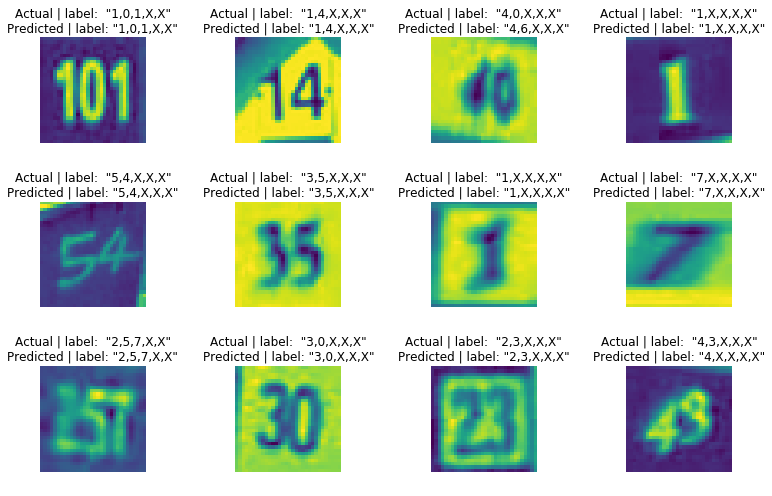

In [830]:
from keras.preprocessing.image import array_to_img

fig = plt.figure(figsize=(11, 7))
i = 1
rows = 3
columns = 4
labels = {}

for c in np.random.choice(len(x_test_final), rows * columns):
    fig.add_subplot(rows, columns, i)
    i += 1
    
    for digit in range(0,5):
        labAll = ''
        labels[digit] = np.argmax(y_test_final[digit][c])
        labAll = labAll + str(labels[digit])
    #labels = y_train_final[0][c]
    titleString = "Actual | label: "# + labAll # str(labels) #str(labels[0])
    titleString += " \""
    for j in range(0,5):
        dig = int(labels[j])
        if dig == 10:
            dig = "X"
        else:
            dig = str(dig)
        titleString += dig + ","
    titleString = titleString[:-1] + "\"\nPredicted | "
    
    pred = model.predict(x_test_final[c:c+1])
    titleString += "label:" #+ str(np.argmax(pred[0][0]))
    titleString += " \""
    for j in range(0,5):
        dig = np.argmax(pred[j][0])
        if dig == 10:
            dig = "X"
        else:
            dig = str(dig)
        titleString += dig + ","
    titleString = titleString[:-1] + "\""
    plt.title(titleString)
    plt.axis("off")
    um_img = x_test_final[c][:,:,0]
    plt.imshow(um_img + abs(um_img.min()))
plt.tight_layout()
plt.show()

In [519]:
str(labels)

'{0: 2, 1: 8, 2: 10, 3: 10, 4: 10}'

In [745]:
initModel.history['val_D1_acc']

[0.0859375,
 0.1328125,
 0.09375,
 0.1953125,
 0.296875,
 0.28125,
 0.359375,
 0.375,
 0.4140625,
 0.4140625]

In [784]:
print(initModel.history.keys())

dict_keys(['val_loss', 'val_D1_loss', 'val_D2_loss', 'val_D3_loss', 'val_D4_loss', 'val_D5_loss', 'val_D1_acc', 'val_D1_precision', 'val_D1_recall', 'val_D1_fmeasure', 'val_D2_acc', 'val_D2_precision', 'val_D2_recall', 'val_D2_fmeasure', 'val_D3_acc', 'val_D3_precision', 'val_D3_recall', 'val_D3_fmeasure', 'val_D4_acc', 'val_D4_precision', 'val_D4_recall', 'val_D4_fmeasure', 'val_D5_acc', 'val_D5_precision', 'val_D5_recall', 'val_D5_fmeasure', 'loss', 'D1_loss', 'D2_loss', 'D3_loss', 'D4_loss', 'D5_loss', 'D1_acc', 'D1_precision', 'D1_recall', 'D1_fmeasure', 'D2_acc', 'D2_precision', 'D2_recall', 'D2_fmeasure', 'D3_acc', 'D3_precision', 'D3_recall', 'D3_fmeasure', 'D4_acc', 'D4_precision', 'D4_recall', 'D4_fmeasure', 'D5_acc', 'D5_precision', 'D5_recall', 'D5_fmeasure'])


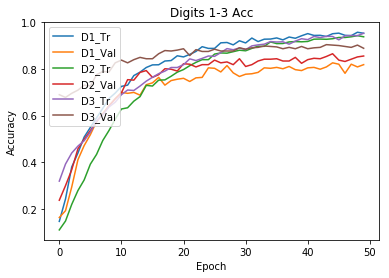

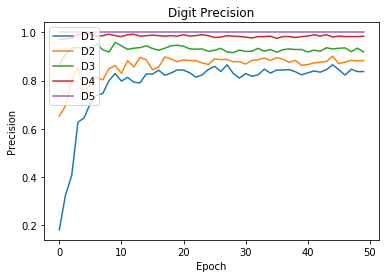

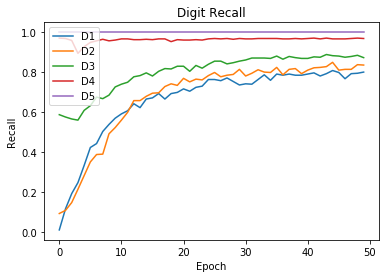

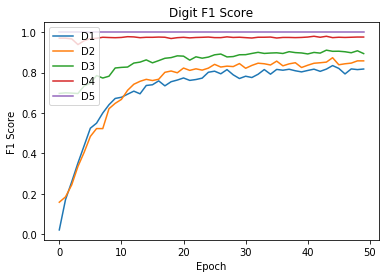

In [831]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(initModel.history['D1_acc'])
plt.plot(initModel.history['val_D1_acc'])
plt.plot(initModel.history['D2_acc'])
plt.plot(initModel.history['val_D2_acc'])
plt.plot(initModel.history['D3_acc'])
plt.plot(initModel.history['val_D3_acc'])
plt.title('Digits 1-3 Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['D1_Tr', 'D1_Val', 'D2_Tr', 'D2_Val', 'D3_Tr', 'D3_Val'], loc='upper left')
plt.savefig('D1-2-3_trValAcc.png')
plt.show()


# Plot training & validation loss values
plt.plot(initModel.history['val_D1_precision'])
plt.plot(initModel.history['val_D2_precision'])
plt.plot(initModel.history['val_D3_precision'])
plt.plot(initModel.history['val_D4_precision'])
plt.plot(initModel.history['val_D5_precision'])
plt.title('Digit Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['D1', 'D2', 'D3', 'D4', 'D5'], loc='upper left')
plt.savefig('D1-5_ValPrec.png')
plt.show()

# Plot training & validation loss values
plt.plot(initModel.history['val_D1_recall'])
plt.plot(initModel.history['val_D2_recall'])
plt.plot(initModel.history['val_D3_recall'])
plt.plot(initModel.history['val_D4_recall'])
plt.plot(initModel.history['val_D5_recall'])
plt.title('Digit Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['D1', 'D2', 'D3', 'D4', 'D5'], loc='upper left')
plt.savefig('D1-5_ValRec.png')
plt.show()

# Plot training & validation loss values
plt.plot(initModel.history['val_D1_fmeasure'])
plt.plot(initModel.history['val_D2_fmeasure'])
plt.plot(initModel.history['val_D3_fmeasure'])
plt.plot(initModel.history['val_D4_fmeasure'])
plt.plot(initModel.history['val_D5_fmeasure'])
plt.title('Digit F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['D1', 'D2', 'D3', 'D4', 'D5'], loc='upper left')
plt.savefig('D1-5_valF1Score.png')
plt.show()

In [750]:
# Save model: https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_svhnII_trained_model.h5'
completeName = os.path.join(save_dir, model_name) 

model.save(completeName)

In [107]:
print(noDataAugModel.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


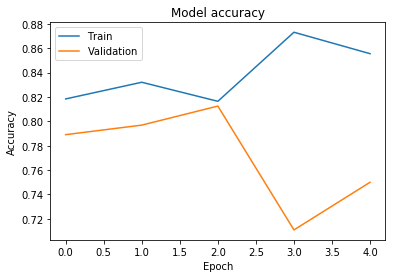

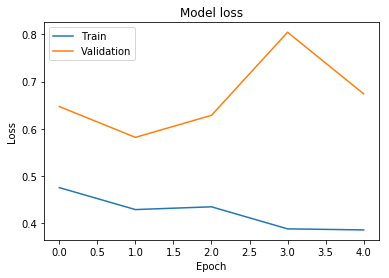

Test loss: 0.6738657876849174
Test accuracy: 0.75


In [108]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(noDataAugModel.history['acc'])
plt.plot(noDataAugModel.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(noDataAugModel.history['loss'])
plt.plot(noDataAugModel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])